Please find torch implementation of this notebook here: https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/book1/20/skipgram_torch.ipynb


# Learning word emebddings using skipgram with negative sampling.

Based on D2L 14.3 http://d2l.ai/chapter_natural-language-processing-pretraining/word-embedding-dataset.html and 14.4 of http://d2l.ai/chapter_natural-language-processing-pretraining/word2vec-pretraining.html.



In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math

import os
import random

random.seed(0)

import jax
import jax.numpy as jnp

try:
    from flax import linen as nn
except ModuleNotFoundError:
    %pip install -qq flax
    from flax import linen as nn
from flax.training import train_state

try:
    import optax
except ModuleNotFoundError:
    %pip install -qq optax
    import optax
try:
    import torch
except ModuleNotFoundError:
    %pip install -qq torch
    import torch

import requests
import zipfile
import tarfile
import hashlib
import collections
from IPython import display
import time

!mkdir figures # for saving plots

# Data

We use the Penn Tree Bank (PTB), which is a small but commonly-used corpus derived from the Wall Stree Journal.


In [3]:
# Required functions for downloading data


def download(name, cache_dir=os.path.join("..", "data")):
    """Download a file inserted into DATA_HUB, return the local filename."""
    assert name in DATA_HUB, f"{name} does not exist in {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split("/")[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, "rb") as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # Hit cache
    print(f"Downloading {fname} from {url}...")
    r = requests.get(url, stream=True, verify=True)
    with open(fname, "wb") as f:
        f.write(r.content)
    return fname


def download_extract(name, folder=None):
    """Download and extract a zip/tar file."""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == ".zip":
        fp = zipfile.ZipFile(fname, "r")
    elif ext in (".tar", ".gz"):
        fp = tarfile.open(fname, "r")
    else:
        assert False, "Only zip/tar files can be extracted."
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

In [4]:
DATA_HUB = dict()
DATA_URL = "http://d2l-data.s3-accelerate.amazonaws.com/"

DATA_HUB["ptb"] = (DATA_URL + "ptb.zip", "319d85e578af0cdc590547f26231e4e31cdf1e42")


def read_ptb():
    data_dir = download_extract("ptb")
    with open(os.path.join(data_dir, "ptb.train.txt")) as f:
        raw_text = f.read()
    return [line.split() for line in raw_text.split("\n")]


sentences = read_ptb()
f"# sentences: {len(sentences)}"

'# sentences: 42069'

We make a vocabulary, replacing any word that occurs less than 10 times with unk.

In [5]:
class Vocab:
    """Vocabulary for text."""

    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # Sort according to frequencies
        counter = count_corpus(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True)
        # The index for the unknown token is 0
        self.unk, uniq_tokens = 0, ["<unk>"] + reserved_tokens
        uniq_tokens += [token for token, freq in self.token_freqs if freq >= min_freq and token not in uniq_tokens]
        self.idx_to_token, self.token_to_idx = [], dict()
        for token in uniq_tokens:
            self.idx_to_token.append(token)
            self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]


def count_corpus(tokens):
    """Count token frequencies."""
    # Here `tokens` is a 1D list or 2D list
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # Flatten a list of token lists into a list of tokens
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

In [6]:
vocab = Vocab(sentences, min_freq=10)
f"vocab size: {len(vocab)}"

'vocab size: 6719'

Mikolov suggested keeping word $w$ with probability
$$
\sqrt{\theta / f(w)}
$$
where $\theta=10^{-4}$ is a threshold, and $f(w)=N(w)/N$ is the empirical frequency of word $w$.

In [7]:
def count_corpus(tokens):
    """Count token frequencies."""
    # Here `tokens` is a 1D list or 2D list
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # Flatten a list of token lists into a list of tokens
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

In [8]:
def subsampling(sentences, vocab):
    # Map low frequency words into <unk>
    sentences = [[vocab.idx_to_token[vocab[tk]] for tk in line] for line in sentences]
    # Count the frequency for each word
    counter = count_corpus(sentences)
    num_tokens = sum(counter.values())

    # Return True if to keep this token during subsampling
    def keep(token):
        return random.uniform(0, 1) < math.sqrt(1e-4 / counter[token] * num_tokens)

    # Now do the subsampling
    return [[tk for tk in line if keep(tk)] for line in sentences]


subsampled = subsampling(sentences, vocab)

We compare the frequency of certain common and rare words in the original and subsampled data below.

In [9]:
def compare_counts(token):
    return (
        f'# of "{token}": '
        f"before={sum([line.count(token) for line in sentences])}, "
        f"after={sum([line.count(token) for line in subsampled])}"
    )


print(compare_counts("the"))
print(compare_counts("join"))

# of "the": before=50770, after=2103
# of "join": before=45, after=45


Let's tokenize the subsampled data.


In [10]:
corpus = [vocab[line] for line in subsampled]

print(corpus[0:3])

[[], [2115, 145, 0, 406], [0, 5277, 3054, 1580]]


## Extracting central target words and their contexts

We randomly sample a context length for each central word, up to some maximum length, and then extract all the context words as a list of lists.

In [11]:
def get_centers_and_contexts(corpus, max_window_size):
    centers, contexts = [], []
    for line in corpus:
        # Each sentence needs at least 2 words to form a "central target word
        # - context word" pair
        if len(line) < 2:
            continue
        centers += line
        for i in range(len(line)):  # Context window centered at i
            window_size = random.randint(1, max_window_size)
            indices = list(range(max(0, i - window_size), min(len(line), i + 1 + window_size)))
            # Exclude the central target word from the context words
            indices.remove(i)
            contexts.append([line[idx] for idx in indices])
    return centers, contexts

Example. Suppose we have a corpus with 2 sentences of length 7 and 3, and we use a max context of size 2. Here are the centers and contexts.

In [12]:
tiny_dataset = [list(range(7)), list(range(7, 10))]
print("dataset", tiny_dataset)
for center, context in zip(*get_centers_and_contexts(tiny_dataset, 2)):
    print("center", center, "has contexts", context)

dataset [[0, 1, 2, 3, 4, 5, 6], [7, 8, 9]]
center 0 has contexts [1, 2]
center 1 has contexts [0, 2, 3]
center 2 has contexts [0, 1, 3, 4]
center 3 has contexts [1, 2, 4, 5]
center 4 has contexts [3, 5]
center 5 has contexts [4, 6]
center 6 has contexts [4, 5]
center 7 has contexts [8, 9]
center 8 has contexts [7, 9]
center 9 has contexts [7, 8]


Extract context for the full dataset.

In [13]:
all_centers, all_contexts = get_centers_and_contexts(corpus, 5)
f"# center-context pairs: {len(all_centers)}"

'# center-context pairs: 353301'

## Negative sampling

For speed, we define a sampling class that pre-computes 10,000 random indices from the weighted distribution, using a single call to `random.choices`, and then sequentially returns elements of this list. If we reach the end of the cache, we refill it.

In [14]:
class RandomGenerator:
    """Draw a random int in [0, n] according to n sampling weights."""

    def __init__(self, sampling_weights):
        self.population = list(range(len(sampling_weights)))
        self.sampling_weights = sampling_weights
        self.candidates = []
        self.i = 0

    def draw(self):
        if self.i == len(self.candidates):
            self.candidates = random.choices(self.population, self.sampling_weights, k=10000)
            self.i = 0
        self.i += 1
        return self.candidates[self.i - 1]

Example.

In [15]:
generator = RandomGenerator([2, 3, 4])
[generator.draw() for _ in range(10)]

[2, 0, 1, 2, 2, 2, 2, 2, 2, 1]

Now we generate $K$ negatives for each context. These are drawn from $p(w) \propto \text{freq}(w)^{0.75}$.

In [16]:
def get_negatives(all_contexts, corpus, K):
    counter = count_corpus(corpus)
    sampling_weights = [counter[i] ** 0.75 for i in range(len(counter))]
    all_negatives, generator = [], RandomGenerator(sampling_weights)
    for contexts in all_contexts:
        negatives = []
        while len(negatives) < len(contexts) * K:
            neg = generator.draw()
            # Noise words cannot be context words
            if neg not in contexts:
                negatives.append(neg)
        all_negatives.append(negatives)
    return all_negatives


all_negatives = get_negatives(all_contexts, corpus, 5)

## Minibatching

Suppose the $i$'th central word has $n_i$ contexts and $m_i$ noise words.
Since $n_i+m_i$ might be different for each $i$ (due to edge effects), the minibatch will be ragged. To fix this, we pad to a maximum length $L$, and then create a validity mask of length $L$, where 0 means invalid location (to be ignored when computing the loss) and 1 means valid location. We assign the label vector to have $n_i$ 1's and $L-n_i$ 0's. (Some of these labels will be masked out.)


In [17]:
def batchify(data):
    max_len = max(len(c) + len(n) for _, c, n in data)
    centers, contexts_negatives, masks, labels = [], [], [], []
    for center, context, negative in data:
        cur_len = len(context) + len(negative)
        centers += [center]
        contexts_negatives += [context + negative + [0] * (max_len - cur_len)]
        masks += [[1] * cur_len + [0] * (max_len - cur_len)]
        labels += [[1] * len(context) + [0] * (max_len - len(context))]
    return (np.array(centers).reshape((-1, 1)), np.array(contexts_negatives), np.array(masks), np.array(labels))

Example. We make a ragged minibatch with 2 examples, and then pad them to a standard size.

In [18]:
x_1 = (1, [2, 2], [3, 3, 3, 3])
x_2 = (1, [2, 2, 2], [3, 3])
batch = batchify((x_1, x_2))

names = ["centers", "contexts_negatives", "masks", "labels"]
for name, data in zip(names, batch):
    print(name, "=", data)

centers = [[1]
 [1]]
contexts_negatives = [[2 2 3 3 3 3]
 [2 2 2 3 3 0]]
masks = [[1 1 1 1 1 1]
 [1 1 1 1 1 0]]
labels = [[1 1 0 0 0 0]
 [1 1 1 0 0 0]]


## Dataloader

Now we put it altogether.

In [19]:
def load_data_ptb(batch_size, max_window_size, num_noise_words):
    num_workers = 2
    sentences = read_ptb()
    vocab = Vocab(sentences, min_freq=10)
    subsampled = subsampling(sentences, vocab)
    corpus = [vocab[line] for line in subsampled]
    all_centers, all_contexts = get_centers_and_contexts(corpus, max_window_size)
    all_negatives = get_negatives(all_contexts, corpus, num_noise_words)

    class PTBDataset(torch.utils.data.Dataset):
        def __init__(self, centers, contexts, negatives):
            assert len(centers) == len(contexts) == len(negatives)
            self.centers = centers
            self.contexts = contexts
            self.negatives = negatives

        def __getitem__(self, index):
            return (self.centers[index], self.contexts[index], self.negatives[index])

        def __len__(self):
            return len(self.centers)

    dataset = PTBDataset(all_centers, all_contexts, all_negatives)

    data_iter = torch.utils.data.DataLoader(
        dataset, batch_size, shuffle=True, collate_fn=batchify, num_workers=num_workers
    )
    return data_iter, vocab

Let's print the first minibatch.

In [20]:
data_iter, vocab = load_data_ptb(512, 5, 5)
for batch in data_iter:
    for name, data in zip(names, batch):
        print(name, "shape:", data.shape)
    break

centers shape: (512, 1)
contexts_negatives shape: (512, 60)
masks shape: (512, 60)
labels shape: (512, 60)


In [21]:
batch_size, max_window_size, num_noise_words = 512, 5, 5
data_iter, vocab = load_data_ptb(batch_size, max_window_size, num_noise_words)

# Model

The model just has 2 embedding matrices, $U$ and $V$. The core computation is computing the logits, as shown below.
The center variable has the shape (batch size, 1), while the contexts_and_negatives variable has the shape (batch size, max_len). These get embedded into size $(B,1,E)$ and $(B,L,E)$. We permute the latter to $(B,E,L)$ and use matrix multiplication to get $(B,1,L)$ matrix of inner products between each center's embedding and each context's embedding.


In [22]:
class SkipGram(nn.Module):
    vocab_size: int
    embed_size: int

    @nn.compact
    def __call__(self, center, contexts_and_negatives):
        v = nn.Embed(self.vocab_size, self.embed_size)(center)
        u = nn.Embed(self.vocab_size, self.embed_size)(contexts_and_negatives)
        pred = jax.vmap(jnp.matmul)(v, u.transpose(0, 2, 1))
        return pred

Example. Assume the vocab size is 20 and we use $E=4$ embedding dimensions.
We compute the logits for a minibatch of $B=2$ sequences, with max length $L=4$.

In [23]:
center = jnp.ones((2, 1), dtype=jnp.int32)
contexts_and_negatives = jnp.ones((2, 4), dtype=jnp.int32)
skip_gram = SkipGram(20, 4)
variables = skip_gram.init(jax.random.PRNGKey(0), center, contexts_and_negatives)
print(
    f"Parameter embedding_weight ({variables['params']['Embed_0']['embedding'].shape}, "
    f"dtype={variables['params']['Embed_0']['embedding'].dtype})"
)

skip_gram.apply(variables, center, contexts_and_negatives).shape

Parameter embedding_weight ((20, 4), dtype=float32)


(2, 1, 4)

# Loss

We use masked binary cross entropy loss.


In [24]:
def sigmoid_bce_loss(inputs, target, mask=None):
    """BCE with logit loss, based on https://github.com/pytorch/pytorch/blob/1522912602bc4cc5f7adbce66cad00ebb436f195/aten/src/ATen/native/Loss.cpp#L317"""
    max_val = jnp.clip(-inputs, 0, None)
    loss = (1 - target) * inputs + max_val + jnp.log(jnp.exp(-max_val) + jnp.exp((-inputs - max_val)))
    if mask is not None:
        loss = loss * mask
    return loss.mean(axis=1)

In [25]:
pred = jnp.array([[0.5] * 4] * 2)
label = jnp.array([[1.0, 0.0, 1.0, 0.0]] * 2)
mask = jnp.array([[1, 1, 1, 1], [1, 1, 0, 0]])
sigmoid_bce_loss(pred, label, mask)

DeviceArray([0.724077 , 0.3620385], dtype=float32)

Different masks can lead to different results.

If we normalize by the number of valid masked entries, then predictions with the same per-token accuracy will score the same.

In [26]:
sigmoid_bce_loss(pred, label, mask) / mask.sum(axis=1) * mask.shape[1]

DeviceArray([0.724077, 0.724077], dtype=float32)

# Training

In [27]:
# Functions for plotting and accumulating sum
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()


class Animator:
    """For plotting data in animation."""

    def __init__(
        self,
        xlabel=None,
        ylabel=None,
        legend=None,
        xlim=None,
        ylim=None,
        xscale="linear",
        yscale="linear",
        fmts=("-", "m--", "g-.", "r:"),
        nrows=1,
        ncols=1,
        figsize=(3.5, 2.5),
    ):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        display.set_matplotlib_formats("svg")
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [
                self.axes,
            ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: set_axes(self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)


class Accumulator:
    """For accumulating sums over `n` variables."""

    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [28]:
def create_train_state(rng, learning_rate, embed_size):
    """Creates initial `TrainState`."""
    net = SkipGram(len(vocab), embed_size)
    params = net.init(
        rng,
        jnp.ones([1, 1], dtype=jnp.int32),
        jnp.ones([1, max_window_size * 2 * (num_noise_words + 1)], dtype=jnp.int32),
    )["params"]
    tx = optax.adam(learning_rate)
    return train_state.TrainState.create(apply_fn=net.apply, params=params, tx=tx)

In [29]:
@jax.jit
def train_step(state, batch):
    """Train for a single step."""
    center, context_negative, mask, label = batch

    def loss_fn(params):
        pred = state.apply_fn({"params": params}, center, context_negative)
        loss = sigmoid_bce_loss(pred.reshape(label.shape), label, mask) / mask.sum(axis=1) * mask.shape[1]
        return jnp.sum(loss)

    grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss

In [30]:
def train(data_iter, lr, num_epochs, embed_size):
    rng = jax.random.PRNGKey(1)
    state = create_train_state(rng, lr, embed_size)

    animator = Animator(xlabel="epoch", ylabel="loss", xlim=[1, num_epochs])
    metric = Accumulator(2)  # Sum of losses, no. of tokens
    for epoch in range(num_epochs):
        seconds, num_batches = time.time(), len(data_iter)
        for i, batch in enumerate(data_iter):
            state, loss = train_step(state, list(map(jnp.array, batch)))
            metric.add(loss, batch[0].shape[0])
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches, (metric[0] / metric[1],))
    device = jax.default_backend()
    print(
        f"loss {metric[0] / metric[1]:.3f}, " f"{metric[1] / (time.time() - seconds):.1f} tokens/sec on {str(device)}"
    )
    return state

loss 0.375, 171251.0 tokens/sec on gpu


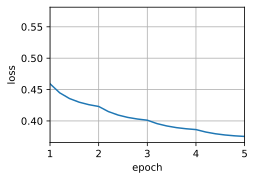

In [31]:
embed_size = 100
lr, num_epochs = 0.01, 5
state = train(data_iter, lr, num_epochs, embed_size)

# Test

We find the $k$ nearest words to the query, where we measure similarity using cosine similarity
$$\text{sim} = \frac{x^T y}{||x|| \; ||y||}$$


In [32]:
def get_similar_tokens(query_token, k, state):
    W = state.params["Embed_0"]["embedding"]
    x = W[vocab[query_token]]
    # Compute the cosine similarity. Add 1e-9 for numerical stability
    cos = jnp.dot(W, x) / jnp.sqrt(jnp.sum(W * W, axis=1) * jnp.sum(x * x) + 1e-9)
    topk = jax.lax.top_k(cos, k + 1)[1]
    for i in topk[1:]:  # Remove the input words
        print(f"cosine sim={float(cos[i]):.3f}: {vocab.idx_to_token[i]}")

In [33]:
get_similar_tokens("chip", 3, state)

cosine sim=0.453: systems
cosine sim=0.447: microprocessor
cosine sim=0.433: users


In [34]:
get_similar_tokens("president", 3, state)

cosine sim=0.531: executive
cosine sim=0.477: thomas
cosine sim=0.476: vice


In [35]:
get_similar_tokens("dog", 3, state)

cosine sim=0.410: admission
cosine sim=0.407: neck
cosine sim=0.403: has


# Pre-trained models

For better results, you should use a larger model that is trained on more data,
such as those provided by the [Spacy library](https://spacy.io/usage/linguistic-features#vectors-similarity). For a demo, see [this script](https://github.com/probml/pyprobml/blob/master/scripts/word_embedding_spacy.py).